In [401]:
import pandas as pd
import numpy as np
import os
import pandas as pd

In [402]:
#dataset contains k as thousand within the like_count and None as 0 within the reply_count. This is both not applicable for dividing. Additionally, the columns are saved as object and need to be converted into float64
def convert_k_to_thousand(value):
    """
    Convert a string number into a float.
    '2.1k' or '2.1K' -> 2100.0
    'none' or '0' -> 1
    """
    value_str = str(value).lower()
    if 'k' in value_str:
        return float(value_str.replace('k', '')) * 1000
    elif value_str == 'none' or value_str == '0':
        return 1.0  # return 1 for 'none' and '0'
    try:
        return float(value_str)
    except ValueError:
        return np.nan  # return NaN for non-numeric strings
    pass

In [403]:
#buckets are there too split the dataset into relative sectors. In this case 10 equal sized sectors/buckets of each dataset. Different datasets have different no. of buckets
def bucket_positions(df):
    df['position_bucket'] = pd.qcut(df['position'], q=10, labels=False)
    return df

In [404]:
#creates a list of dataframes
#directory path where Excel files are stored
excel_dir = r'C:\Users\morit\OneDrive\Dokumente\Kommentar-Algorithmus\Seminar\data'
excel_files = [f for f in os.listdir(excel_dir) if f.endswith('.xlsx')]
dataframes = []
irrelevant_columns = ['vedio_url', 'content', 'dislike_count', 'reply_user', 
                      'reply_content', 'reply_comment_time', 'reply_like_count', 
                      'reply_dislike_count', 'post_comment_count', 'CrawlTime']

In [405]:
#Invoking dataframes and dropping unnecessary columns 
for file in excel_files:
    df = pd.read_excel(os.path.join(excel_dir, file))
    
    #Drops irrelevant columns
    df = df.drop(irrelevant_columns, axis=1)
    #Converts 'like_count' and 'reply_count' columns to numeric
    df['like_count'] = df['like_count'].apply(convert_k_to_thousand)
    df['reply_count'] = df['reply_count'].apply(convert_k_to_thousand)
    #Computes UII
    df['user_interaction_index'] = df['reply_count'] / df['like_count']
    
    #Adds position
    df['position'] = range(1, len(df) + 1)
    
    #Applies the bucket_positions function to get relative representations of each dataset
    df = bucket_positions(df)
    #Adds video ID
    video_id = os.path.splitext(file)[0]
    df['video_id'] = video_id
    # Adds to the list
    dataframes.append(df)

#Combines all the dataframes into a single dataframe
combined_df = pd.concat(dataframes)

In [406]:
#Groups by 'video_id' and then counts the number of comments for each video
comment_counts = combined_df.groupby('video_id').size()

#Prints the comment counts for each video
print("Comment counts for each video: ", comment_counts)


Comment counts for each video:  video_id
CBS                  763
CBS2                 493
CBS3                 753
CBS4                 825
CBS5                 706
CBS6                 687
CNN1                 762
CNN2                 558
FOX1                 749
FOX2.sxls            584
bild1                861
bild10               688
bild11               494
bild12               290
bild13               688
bild14               868
bild2                580
bild3                580
bild4                822
bild5                837
bild6                815
bild7                532
bild8                212
bild9                937
heuteShow1           632
heuteShow2           854
heuteShow3           714
heuteShow4           821
heuteShow5           888
heuteShow6           847
klimaaktivismus1    1054
klimaaktivismus2     565
klimaaktivismus3     599
klimaaktivismus4     374
spiegel1             322
spiegel2             950
spiegel3             503
spiegel4             547
sportscha

In [407]:
#combining the dataframes. 
#The single dataset contains each entry of each selected YouTube video 
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.to_excel('CDF.xlsx', index=False)
#filtered_df = combined_df[(combined_df['like_count'] >= 5) & (combined_df['like_count'] <= 200)]
filtered_df = combined_df[combined_df['like_count'] >= 5]

In [408]:
#we have to include a comments popularity to mitigate bias. A comment with 1000 likes and 100 answers on pos. 20 is more unusual than a comment with 10 likes and 1 answer at position 10.
#Therefore, several like ranges (classes) are defined which represent comments of similar popularity regarding their likes
#The more popular a comment is, the smaller the range steps (i.e., within 100 likes 20 ranges are created, whereas between 300 and 400 likes only 10 like ranges are created)
#We then calculate the average position of each class 
#A hyperparameter is then introduced to adjust which comments should be considered for comparing
#For example, if the hyperparameter is set on 6, it means that only comments are compared to the average reference point, that have 6 times more replies than their average neighbours. 
#Chance: The higher the hyperparameter, the more likely is an ongoing discussion
#Bias: The higher the parameter, the less representative is the result since there are less data instances which can be considered

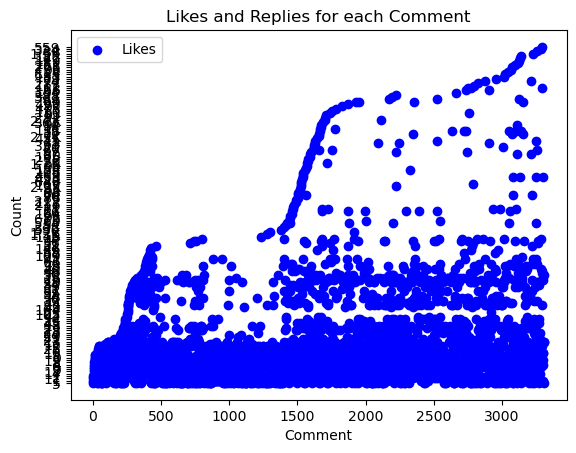

In [409]:
import matplotlib.pyplot as plt

#Loads the dataset
dataset_path = r'C:\Users\morit\OneDrive\Dokumente\Kommentar-Algorithmus\Seminar\data_trash\spiegel5.xlsx'
dataset_df = pd.read_excel(dataset_path)

#Gets the number of likes and replies for each comment in the dataset
likes = dataset_df['like_count'].values
#replies = dataset_df['reply_count'].values


#Creates an array of x-values for the comments
comments = range(1, len(dataset_df) + 1)

#Plots the number of likes
plt.scatter(comments, likes, color='blue', label='Likes')

#Plots the number of replies
#plt.scatter(comments, replies, color='red', label='Replies')

plt.xlabel('Comment')
plt.ylabel('Count')
plt.title('Likes and Replies for each Comment')
plt.legend()
plt.show()


In [410]:
def classify_like_range(likes):
    if likes < 100:
        return likes // 5  # 20 ranges for 0-99 likes
    elif likes < 300:
        return 20 + (likes - 100) // 10  # 20 ranges for 100-299 likes
    elif likes < 600:
        return 40 + (likes - 300) // 20  # 15 ranges for 300-599 likes
    elif likes < 1000:
        return 55 + (likes - 600) // 100  # 1 range for each 100 likes for 600-999 likes
    elif likes < 3000:
        return 59 + (likes - 1000) // 200  # 1 range for each 200 likes for 1000-2999 likes
    else:
        return 69  #For 3000 and above, all comments should be assigned to the same like range, no. 69
#69 classes have been created. Class 69 is a collection of all comments with more than 3000 likes
#Now, we can apply this function to the DataFrame
filtered_df['like_range_class'] = filtered_df['like_count'].apply(classify_like_range)
filtered_df['relative_position'] = filtered_df.groupby('video_id')['position'].apply(lambda x: x / x.max())

C:\Users\morit\AppData\Local\Temp\ipykernel_5828\2364720496.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['like_range_class'] = filtered_df['like_count'].apply(classify_like_range)
C:\Users\morit\AppData\Local\Temp\ipykernel_5828\2364720496.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['relative_position'] = filtered_df.groupby('video_id')['position'].apply(lambda x: x / x.max())


In [411]:
#we have to calculate the mean of all comments which do have more replies than the avg reply count of their class.
filtered_df['mean_reply_count'] = filtered_df.groupby('like_range_class')['reply_count'].transform('mean')
filtered_df.to_excel('filtered_dfs.xlsx')
filtered_df.tail()

C:\Users\morit\AppData\Local\Temp\ipykernel_5828\2141063905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['mean_reply_count'] = filtered_df.groupby('like_range_class')['reply_count'].transform('mean')


,comment_user,comment_time,like_count,reply_count,user_interaction_index,position,position_bucket,video_id,like_range_class,relative_position,mean_reply_count
37904,@Nbaclout922,3 years ago,8.0,1.0,0.125000,686,6,vice2,1.0,0.967560,1.703568
37907,@adamp4428,3 years ago,11.0,1.0,0.090909,689,6,vice2,2.0,0.971791,2.177690
37913,@KN-yk9lp,3 years ago,10.0,5.0,0.500000,695,6,vice2,2.0,0.980254,2.177690
37915,@John_Nada_,3 years ago,23.0,1.0,0.043478,697,6,vice2,4.0,0.983075,2.838362
37927,@acidityparrots2127,3 years ago,28.0,3.0,0.107143,709,6,vice2,5.0,1.000000,3.360563


In [412]:
#Now all comments are considered for the position comparison.
#the class which is chosen can be modified to either single classes, ranges of whole classes or all classes ontogehter. For example, 20 would calculate measure the values for the first 100 comments of each dataset.
# Select class <=69
#we dont consider comments with less than 5 likes. This is since these comments would bias the result for mean relative position of comments with below or equal to x times the average replies. Since there are many unrelevant (unpopular comments), most of them are placed in the middle and bottom areas of the section. Therefore, the calculation would overrepresent the results.
#test result if comments below 5 likes are also consideres: 0.62 vs. 0.56. It is clearly visible how the second value is biased due to the overrepresentation of comments with no popularity and therefore placed in farther secion areas.
df_class_selected = filtered_df[filtered_df['like_range_class'] <= 69]

# Defines hyperparameter x as a threshold by creating new column 'x_mean_reply_count' which is x times the mean reply count for each class
df_class_selected['x_mean_reply_count'] = df_class_selected['mean_reply_count'] * 8

#Now calculating the mean positions of comments with lower and higher reply counts (based on the hyperparameter)
mean_position_above_avg = df_class_selected[df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']]['relative_position'].mean()
mean_position_below_avg = df_class_selected[df_class_selected['reply_count'] <= df_class_selected['x_mean_reply_count']]['relative_position'].mean()

print(f"For class 65:\n Mean relative position of comments with above 5 times the average replies: {mean_position_above_avg}")
print(f"Mean relative position of comments with below or equal to 5 times the average replies: {mean_position_below_avg}")
print({})

For class 65:
 Mean relative position of comments with above 5 times the average replies: 0.5084883826224272
Mean relative position of comments with below or equal to 5 times the average replies: 0.39516813669601325
{}


In [413]:
num_comments_above_threshold = df_class_selected[df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']].shape[0]
print(f"The number of comments that have more than 5 times replies than the mean reply count: {num_comments_above_threshold}")


The number of comments that have more than 5 times replies than the mean reply count: 40


In [414]:
#Defines the range of x values to iterate over
x_values = range(1, 13)

#Now all comments are considered for the position comparison.
df_class_selected = filtered_df[filtered_df['like_range_class'] <= 69]

for x in x_values:
    # Creates a copy of df_class_selected to avoid chaining assignment warning
    df_class_iter = df_class_selected.copy()

    # Defines hyperparameter x as a threshold by creating new column 'x_mean_reply_count' which is x times the mean reply count for each class
    df_class_iter['x_mean_reply_count'] = df_class_iter['mean_reply_count'] * x

    # Filters out comments that have more than 8 times the average replies and have a relative position lower than 0.03
    df_class_iter = df_class_iter[~((df_class_iter['reply_count'] > 5 * df_class_iter['mean_reply_count']) & (df_class_iter['relative_position'] < 0.03))]

    # Now calculates the mean positions of comments with lower and higher reply counts (based on the hyperparameter)
    above_avg_comments = df_class_iter[df_class_iter['reply_count'] > df_class_iter['x_mean_reply_count']]
    below_avg_comments = df_class_iter[df_class_iter['reply_count'] <= df_class_iter['x_mean_reply_count']]

    mean_position_above_avg = above_avg_comments['relative_position'].mean()
    mean_position_below_avg = below_avg_comments['relative_position'].mean()

    # Number of comments in each category
    num_above_avg_comments = len(above_avg_comments)
    num_below_avg_comments = len(below_avg_comments)

    print(f"For x={x}:")
    print(f"Number of comments with above {x} times the average replies: {num_above_avg_comments}")
    print(f"Mean relative position: {mean_position_above_avg}")
    print(f"Number of comments with below or equal to {x} times the average replies: {num_below_avg_comments}")
    print(f"Mean relative position: {mean_position_below_avg}\n")


For x=1:
Number of comments with above 1 times the average replies: 2493
Mean relative position: 0.4091569252460582
Number of comments with below or equal to 1 times the average replies: 6456
Mean relative position: 0.39160384091265027

For x=2:
Number of comments with above 2 times the average replies: 1022
Mean relative position: 0.4285248790497851
Number of comments with below or equal to 2 times the average replies: 7927
Mean relative position: 0.39236409551931567

For x=3:
Number of comments with above 3 times the average replies: 481
Mean relative position: 0.44449233481820305
Number of comments with below or equal to 3 times the average replies: 8468
Mean relative position: 0.3937673356781932

For x=4:
Number of comments with above 4 times the average replies: 268
Mean relative position: 0.48038268745322
Number of comments with below or equal to 4 times the average replies: 8681
Mean relative position: 0.3939039340321435

For x=5:
Number of comments with above 5 times the averag

In [415]:
#Set threshold
x = 9

#Creates the threshold column
df_class_selected['x_mean_reply_count'] = df_class_selected['mean_reply_count'] * x

#Filters out the comments that have above 9 times the average reply
df_above_threshold = df_class_selected[df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']]

#Computes y for each row
df_above_threshold['y'] = df_above_threshold['reply_count'] / df_class_selected['mean_reply_count']

#Prints the comments and their respective relative positions, y values, and like counts
print(df_above_threshold[['relative_position', 'y', 'like_count']])


       relative_position          y  like_count
7571            0.147147  10.748414        39.0
7685            0.489489  10.566058         9.0
7760            0.714715  11.939257        10.0
10005           0.124601   9.392052         6.0
11334           0.148058  13.776493        31.0
11520           0.373786  18.784103         7.0
11534           0.390777  10.671119        50.0
13047           0.476489  10.566058         8.0
13263           0.815047   9.879406        19.0
13314           0.894984  13.316863        11.0
14421           1.000000   9.392052         8.0
15506           0.014831   9.774775       270.0
17192           0.828125   9.089054        16.0
17890           0.961078   9.392052         8.0
20447           0.799649  10.566058         6.0
22213           0.580762  10.561650        13.0
22444           1.000000   9.392052         6.0
22750           0.488294   9.392052         7.0
26688           0.001004  11.748148       838.0
28301           0.888889  20.153989     

C:\Users\morit\AppData\Local\Temp\ipykernel_5828\3188167167.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_above_threshold['y'] = df_above_threshold['reply_count'] / df_class_selected['mean_reply_count']


In [416]:
#Sets threshold
x = 8
relative_position_threshold = 0.03

#Creates the threshold column
df_class_selected['x_mean_reply_count'] = df_class_selected['mean_reply_count'] * x

#Filters the dataframe to remove comments that have above 8 times the average reply and relative position lower than 0.03
df_class_selected = df_class_selected[~((df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']) & (df_class_selected['relative_position'] < relative_position_threshold))]

#Calculates the mean positions of comments with lower and higher reply counts
mean_position_above_avg = df_class_selected[df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']]['relative_position'].mean()
mean_position_below_avg = df_class_selected[df_class_selected['reply_count'] <= df_class_selected['x_mean_reply_count']]['relative_position'].mean()

print(f"For class 65:\n Mean relative position of comments with above 5 times the average replies: {mean_position_above_avg}")
print(f"Mean relative position of comments with below or equal to 5 times the average replies: {mean_position_below_avg}")
print({})


For class 65:
 Mean relative position of comments with above 5 times the average replies: 0.6346432131875313
Mean relative position of comments with below or equal to 5 times the average replies: 0.39516813669601325
{}


In [417]:
df_class_selected = filtered_df[filtered_df['like_range_class'] <= 69]

#Defines hyperparameter x as a threshold by creating new column 'x_mean_reply_count' which is x times the mean reply count for each class
df_class_selected['x_mean_reply_count'] = df_class_selected['mean_reply_count'] * 6

#Now calculating the mean positions of comments with lower and higher reply counts (based on the hyperparameter)
mean_position_above_avg = df_class_selected[df_class_selected['reply_count'] > df_class_selected['x_mean_reply_count']]['relative_position'].mean()
mean_position_below_avg = df_class_selected[df_class_selected['reply_count'] <= df_class_selected['x_mean_reply_count']]['relative_position'].mean()

print(f"For class 65:\n Mean relative position of comments with above 5 times the average replies: {mean_position_above_avg}")
print(f"Mean relative position of comments with below or equal to 5 times the average replies: {mean_position_below_avg}")
print({})

For class 65:
 Mean relative position of comments with above 5 times the average replies: 0.461341833187547
Mean relative position of comments with below or equal to 5 times the average replies: 0.3950078728024358
{}


         user_interaction_index  relative_position
cluster                                           
0.0                    0.138243           0.728158
1.0                    0.095645           0.166362
2.0                    1.176598           0.566148


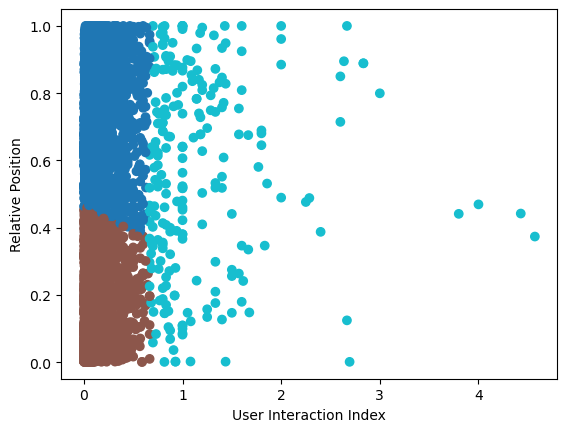

In [418]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

#Defines a colormap
cmap = cm.get_cmap('tab10')  # This is one of the colormaps provided by matplotlib. You can change 'tab10' to the name of any other colormap.

#Only considers the relevant columns
df_clustering = df_class_selected[['user_interaction_index', 'relative_position']].dropna()

#Standardizes the data
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

#Run k-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_clustering_scaled)

#Adds the cluster labels to the original DataFrame
df_class_selected.loc[df_clustering.index, 'cluster'] = kmeans.labels_
print(df_class_selected.groupby('cluster')[['user_interaction_index', 'relative_position']].mean())

# Plots the clusters using the defined colormap
plt.scatter(df_class_selected['user_interaction_index'], df_class_selected['relative_position'], c=df_class_selected['cluster'], cmap=cmap)
plt.xlabel('User Interaction Index')
plt.ylabel('Relative Position')
plt.show()


In [419]:
#Gets cluster labels
labels = kmeans.labels_

#Converts to a pandas Series for easier counting
labels_series = pd.Series(labels)

#Counts the number of data points in each cluster
cluster_counts = labels_series.value_counts()

#Prints the counts
print(cluster_counts)


1    5240
0    3494
2     234
dtype: int64


In [420]:
#Displaying outliers
from scipy.stats import zscore

z_scores = zscore(df_class_selected['reply_count'])
df_class_selected['z_score'] = z_scores

#Filters for data points with a Z-score greater than 3 or less than -3
outliers = df_class_selected[(df_class_selected['z_score'] > 3) | (df_class_selected['z_score'] < -3)]

print(outliers)


              comment_user           comment_time  like_count  reply_count  \
6                S Alcaraz           5 months ago      1000.0         92.0   
16     Matthias Wunderlich           5 months ago      2600.0         78.0   
861           @super-tc7rc            3 weeks ago      1400.0         78.0   
2333                 Bi Bi           4 months ago      2200.0        130.0   
2336    Dirk Peter Hellwig           4 months ago      2000.0         76.0   
...                    ...                    ...         ...          ...   
35232      @marckonrad7851  4 months ago (edited)       722.0        203.0   
36948          @creeds7005            4 years ago      1100.0         79.0   
37237         @kalebs.9559   3 years ago (edited)      2900.0         78.0   
37249     @andrewyoung5915            3 years ago      4300.0         80.0   
37679      @mikerphone4865            3 years ago       550.0         95.0   

       user_interaction_index  position  position_bucket   vide

In [421]:
#Condition which filters all comments with less than 5 likes OR answers (below this threshold, we cannot assume that the unser interaction index is representing a discussion. There still may be some bias!)

condition = (combined_df['like_count'] >= 20) & (combined_df['like_count'] <= 22) & (combined_df['reply_count'] >= 3)

combined_df.loc[condition, 'user_interaction_index'] = combined_df.loc[condition, 'reply_count'] / combined_df.loc[condition, 'like_count'] * 100

#For rows where condition is False,'user_interaction_index' is set to NaN or another value
combined_df.loc[~condition, 'user_interaction_index'] = np.nan

# Verify condition
assert combined_df[condition]['user_interaction_index'].notnull().all()
assert combined_df[~condition]['user_interaction_index'].isnull().all()
combined_df.to_excel('combined_dfs2.xlsx')

In [424]:
condition = (combined_df['like_count'] >= 20) & (combined_df['like_count'] <= 100) & (combined_df['reply_count'] >= 10)

combined_df.loc[condition, 'user_interaction_index'] = combined_df.loc[condition, 'reply_count'] / combined_df.loc[condition, 'like_count'] * 100

#For rows where condition is False,'user_interaction_index' is set to NaN or another value
combined_df.loc[~condition, 'user_interaction_index'] = np.nan

#Verifies condition
assert combined_df[condition]['user_interaction_index'].notnull().all()
assert combined_df[~condition]['user_interaction_index'].isnull().all()
combined_df.to_excel('combined_dfs2.xlsx')
#Calculates mean and median for each bucket
bucket_mean = combined_df.groupby('position_bucket')['user_interaction_index'].mean()
bucket_median = combined_df.groupby('position_bucket')['user_interaction_index'].median()
bucket_count = combined_df.groupby('position_bucket')['user_interaction_index'].count()

#Prints mean, median, and count for each bucket
for bucket, mean_val, median_val, count_val in zip(bucket_mean.index, bucket_mean.values, bucket_median.values, bucket_count.values):
    print(f"Bucket {bucket}: Mean = {mean_val:.2f}, Median = {median_val:.2f}, Count = {count_val}")

Bucket 0: Mean = 26.80, Median = 20.45, Count = 76
Bucket 1: Mean = 39.15, Median = 29.32, Count = 56
Bucket 2: Mean = 30.77, Median = 25.64, Count = 33
Bucket 3: Mean = 32.78, Median = 24.26, Count = 34
Bucket 4: Mean = 29.36, Median = 24.70, Count = 30
Bucket 5: Mean = 30.89, Median = 29.23, Count = 23
Bucket 6: Mean = 35.19, Median = 34.38, Count = 26
Bucket 7: Mean = 45.02, Median = 38.75, Count = 24
Bucket 8: Mean = 46.01, Median = 35.14, Count = 13
Bucket 9: Mean = 50.26, Median = 50.00, Count = 5


Bucket 0: 3849 entries
Bucket 1: 3819 entries
Bucket 2: 3817 entries
Bucket 3: 3821 entries
Bucket 4: 3826 entries
Bucket 5: 3811 entries
Bucket 6: 3818 entries
Bucket 7: 3820 entries
Bucket 8: 3816 entries
Bucket 9: 3847 entries


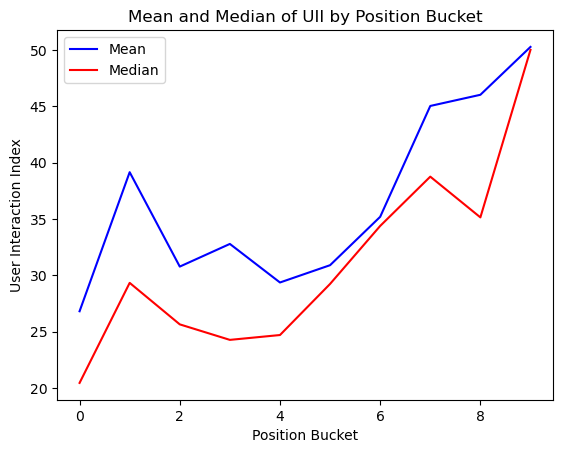

In [425]:
import matplotlib.pyplot as plt

#Calculates mean and median for each bucket
bucket_mean = combined_df.groupby('position_bucket')['user_interaction_index'].mean()
bucket_median = combined_df.groupby('position_bucket')['user_interaction_index'].median()
# Count the number of entries in each bucket after applying the filtering condition
bucket_counts = combined_df.groupby('position_bucket').size()

#Plots mean curve
plt.plot(bucket_mean.index, bucket_mean.values, color='blue', label='Mean')

#Plots median curve
plt.plot(bucket_median.index, bucket_median.values, color='red', label='Median')
#Prints the number of entries in each bucket
for bucket, count in zip(bucket_counts.index, bucket_counts.values):
    print(f"Bucket {bucket}: {count} entries")

plt.xlabel('Position Bucket')
plt.ylabel('User Interaction Index')
plt.title('Mean and Median of UII by Position Bucket')
plt.legend()
plt.show()


In [56]:
import operator
# Calculate the 20% position
#top_20_percent_position = combined_df['position'].quantile(0.2)
# Select first 20% of data
#subset_df = combined_df[combined_df['position'] <= top_20_percent_position]


# Select first 200 buckets
subset_df = combined_df[combined_df['position_bucket'] < 200]

# Prepare data
X_subset = subset_df['position_bucket'].values.reshape(-1, 1)  # reshape for sklearn
y_subset = subset_df['user_interaction_index'].values

# Create Polynomial Features
poly = PolynomialFeatures(degree=6)
X_poly_subset = poly.fit_transform(X_subset)

# Fit Model
model_subset = LinearRegression().fit(X_poly_subset, y_subset)

# Predict
y_poly_pred_subset = model_subset.predict(X_poly_subset)

# Sort the values in ascending order for plotting
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_subset,y_poly_pred_subset), key=sort_axis)
X_subset, y_poly_pred_subset = zip(*sorted_zip)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(X_subset, y_subset, color='b')
plt.plot(X_subset, y_poly_pred_subset, color='m')
plt.ylim(0, 50)
plt.title('Polynomial Regression for first 200 quantiles')
plt.xlabel('Position Bucket')
plt.ylabel('User Interaction Index')
plt.grid(True)
plt.show()


NameError: name 'PolynomialFeatures' is not defined

In [23]:
#here the first 30 comments of each dataset are processed and plotted. 

# Initialize an empty DataFrame
top30_df = pd.DataFrame()

# Loop through each video and add top 30 datapoints to top30_df
for video_id, group in combined_df.groupby('video_id'):
    top_datapoints = group.nsmallest(30, 'position')
    top30_df = pd.concat([top30_df, top_datapoints])

# Now top30_df has the top 30 datapoints from each video

# Prepare data
X_top30 = top30_df['position'].values.reshape(-1, 1)  # reshape for sklearn
y_top30 = top30_df['user_interaction_index'].values

# Create Polynomial Features
poly = PolynomialFeatures(degree=3)
X_poly_top30 = poly.fit_transform(X_top30)

# Fit Model
model_top30 = LinearRegression().fit(X_poly_top30, y_top30)

# Predict
y_poly_pred_top30 = model_top30.predict(X_poly_top30)

# Sort the values in ascending order for plotting
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_top30,y_poly_pred_top30), key=sort_axis)
X_top30, y_poly_pred_top30 = zip(*sorted_zip)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(X_top30, y_top30, color='b')
plt.plot(X_top30, y_poly_pred_top30, color='m')
plt.ylim(0, 25)
plt.title('Polynomial Regression for first 30 datapoints from each video')
plt.xlabel('Position')
plt.ylabel('User Interaction Index')
plt.grid(True)
plt.show()


NameError: name 'PolynomialFeatures' is not defined

In [ ]:
filtered_df.sort_values('position', inplace=True)
result_df = pd.DataFrame(columns=['Comment_ID', 'Distance', 'Class'])
num_comments = 100  # Number of comments to consider

for video_id, group in filtered_df.groupby('video_id'):
    # Select the first 100 comments for each dataset
    group = group.head(num_comments)
    
    # Calculate the distance for each comment
    group['Distance'] = group['position'] - 1
    
    # Assign the class based on the position of the comment
    group['Class'] = pd.cut(group['position'], bins=num_comments, labels=range(1, num_comments + 1))
    
    # Append the results to the result DataFrame
    result_df = pd.concat([result_df, group[['Comment_ID', 'Distance', 'Class']]])